IMPORT NECESSARY LIBRARIES


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from tqdm import tqdm
from sklearn.metrics import precision_recall_fscore_support

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

DATA PREPROCESSING

In [3]:

# Preprocessing transformations with augmentation
transform = transforms.Compose([
    transforms.Resize((28,28)),
    transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
    transforms.RandomRotation(10),      # Slight rotation for robustness
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load dataset with transformations
dataset = ImageFolder(root='./Neural_Network/datasets/cnn_dataset', transform=transform)

# Split dataset into training, validation, and test sets
train_size = int(0.7 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Data loaders with optimized settings
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)


In [4]:
dataset

Dataset ImageFolder
    Number of datapoints: 100800
    Root location: ./Neural_Network/datasets/cnn_dataset
    StandardTransform
Transform: Compose(
               Resize(size=(28, 28), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

DEFINING THE CNN MODEL

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

class LRN(nn.Module):
    # Local Response Normalization layer
    def __init__(self, local_size=5, alpha=1e-4, beta=0.75, k=2.0):
        super(LRN, self).__init__()
        self.local_size = local_size
        self.alpha = alpha
        self.beta = beta
        self.k = k

    def forward(self, x):
        squared_x = x.pow(2)
        local_sum = nn.functional.avg_pool2d(squared_x, self.local_size, stride=1, padding=(self.local_size - 1) // 2)
        scale = self.k + (self.alpha * local_sum).pow(self.beta)
        return x / scale

class VGG_A_LRN(nn.Module):
    def __init__(self, num_classes=36):
        super(VGG_A_LRN, self).__init__()
        
        # Block 1
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            LRN(),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Reduces spatial size to 14x14
        )
        
        # Block 2
        self.block2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Reduces spatial size to 7x7
        )
        
        # Block 3
        self.block3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Reduces spatial size to 3x3
        )
        
        # Block 4 (No MaxPooling here)
        self.block4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        
        # Block 5 (No MaxPooling here)
        self.block5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        
        
        self.classifier = nn.Sequential(
            nn.Linear(512 * 3 * 3, 4096),  # Flattened input size for fully connected layer
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),         # Second fully connected layer
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(4096, num_classes)   # Final output layer
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.classifier(x)
        return x

# Instantiating the model and optimizer with specified settings
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VGG_A_LRN(num_classes=36).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

print(model)


VGG_A_LRN(
  (block1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LRN()
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block4): Se

TRAINING AND VALIDATION

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
from tqdm import tqdm
import warnings

# Suppressing all warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")


def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=6):
    train_accuracies = []
    train_precisions = []
    train_recalls = []
    train_f1_scores = []
    train_losses = []

    val_accuracies = []
    val_precisions = []
    val_recalls = []
    val_f1_scores = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        all_preds = []
        all_labels = []

        print(f"Epoch {epoch + 1}/{num_epochs}")

        for inputs, labels in tqdm(train_loader, desc="Training", unit="batch"):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

        # Calculate metrics
        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct_train / total_train
        precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average="weighted")
        
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        train_precisions.append(precision)
        train_recalls.append(recall)
        train_f1_scores.append(f1)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        val_preds = []
        val_labels = []
        best_val_accuracy = 0.0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_preds.extend(predicted.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)

        val_loss /= len(val_loader)
        val_accuracy = 100 * correct_val / total_val
        val_precision, val_recall, val_f1, _ = precision_recall_fscore_support(val_labels, val_preds, average="weighted")
        
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        val_precisions.append(val_precision)
        val_recalls.append(val_recall)
        val_f1_scores.append(val_f1)

        print(f"Epoch [{epoch + 1}/{num_epochs}] Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%")
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")
        # print(f"Validation Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1 Score: {val_f1:.4f}")
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), "best_vgg_a_lrn_weights.pt")
            print(f"Best model saved with validation accuracy: {val_accuracy:.2f}%")
        # Step the scheduler after each epoch
        scheduler.step()

    return train_accuracies, train_precisions, train_recalls, train_f1_scores, train_losses, val_accuracies, val_precisions, val_recalls, val_f1_scores, val_losses




TESTING

In [7]:
def test_model(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    correct_test = 0
    total_test = 0
    test_preds = []
    test_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Testing", unit="batch"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            test_preds.extend(predicted.cpu().numpy())
            test_labels.extend(labels.cpu().numpy())
            correct_test += (predicted == labels).sum().item()
            total_test += labels.size(0)

    test_loss /= len(test_loader)
    test_accuracy = 100 * correct_test / total_test
    precision, recall, f1, _ = precision_recall_fscore_support(test_labels, test_preds, average="weighted")
    
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")
    print(f"Test Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

    return test_loss, test_accuracy, precision, recall, f1


In [8]:
train_accuracies, train_precisions, train_recalls, train_f1_scores, train_losses, val_accuracies, val_precisions, val_recalls, val_f1_scores, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=6)
# test_loss, test_accuracy = test_model(model, test_loader, criterion)

Epoch 1/6


Training: 100%|██████████| 1103/1103 [14:08<00:00,  1.30batch/s]
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [1/6] Training Loss: 2.4380, Training Accuracy: 21.03%
Validation Loss: 1.2314, Validation Accuracy: 55.49%
Best model saved with validation accuracy: 55.49%
Epoch 2/6


Training: 100%|██████████| 1103/1103 [14:08<00:00,  1.30batch/s]


Epoch [2/6] Training Loss: 0.8048, Training Accuracy: 72.43%
Validation Loss: 0.6314, Validation Accuracy: 78.97%
Best model saved with validation accuracy: 78.97%
Epoch 3/6


Training: 100%|██████████| 1103/1103 [14:07<00:00,  1.30batch/s]


Epoch [3/6] Training Loss: 0.5105, Training Accuracy: 82.79%
Validation Loss: 0.4595, Validation Accuracy: 84.84%
Best model saved with validation accuracy: 84.84%
Epoch 4/6


Training: 100%|██████████| 1103/1103 [14:09<00:00,  1.30batch/s]


Epoch [4/6] Training Loss: 0.4333, Training Accuracy: 85.43%
Validation Loss: 0.4140, Validation Accuracy: 85.82%
Best model saved with validation accuracy: 85.82%
Epoch 5/6


Training: 100%|██████████| 1103/1103 [14:11<00:00,  1.30batch/s]


Epoch [5/6] Training Loss: 0.3884, Training Accuracy: 86.83%
Validation Loss: 0.3978, Validation Accuracy: 86.79%
Best model saved with validation accuracy: 86.79%
Epoch 6/6


Training: 100%|██████████| 1103/1103 [14:08<00:00,  1.30batch/s]


Epoch [6/6] Training Loss: 0.3021, Training Accuracy: 89.35%
Validation Loss: 0.3279, Validation Accuracy: 88.78%
Best model saved with validation accuracy: 88.78%


In [9]:
# print(train_accuracies)
test_loss, test_accuracy, precision, recall, f1= test_model(model, test_loader, criterion)


Testing: 100%|██████████| 315/315 [01:33<00:00,  3.36batch/s]

Test Loss: 0.3147, Test Accuracy: 88.99%
Test Precision: 0.8966, Recall: 0.8899, F1 Score: 0.8879


In [10]:
print(val_losses)

[1.231374617241606, 0.6314256566612026, 0.4595305572582197, 0.41404925135872034, 0.39778099133621286, 0.32792103507473497]


VISUALIZATIONS

In [11]:
def plot_accuracy(train_accuracies, val_accuracies, test_accuracy, num_epochs):
    epochs = range(1, num_epochs + 1)
    test_accuracy_line = [test_accuracy] * num_epochs

    plt.figure()
    plt.plot(epochs, train_accuracies, label="Training Accuracy")
    plt.plot(epochs, val_accuracies, label="Validation Accuracy")
    plt.plot(epochs, test_accuracy_line, label="Test Accuracy", linestyle="--")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.title("Training, Validation, and Test Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()


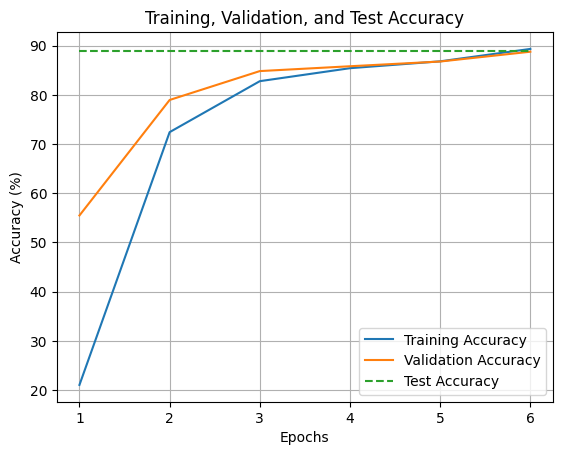

In [12]:
plot_accuracy(train_accuracies, val_accuracies, test_accuracy, num_epochs=6)

In [13]:
def plot_loss(train_losses, val_losses, test_loss, num_epochs):
    epochs = range(1, num_epochs + 1)
    test_loss_line = [test_loss] * num_epochs

    plt.figure()
    plt.plot(epochs, train_losses, label="Training Loss")
    plt.plot(epochs, val_losses, label="Validation Loss")
    plt.plot(epochs, test_loss_line, label="Test Loss", linestyle="--")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training, Validation, and Test Loss")
    plt.legend()
    plt.grid(True)
    plt.show()


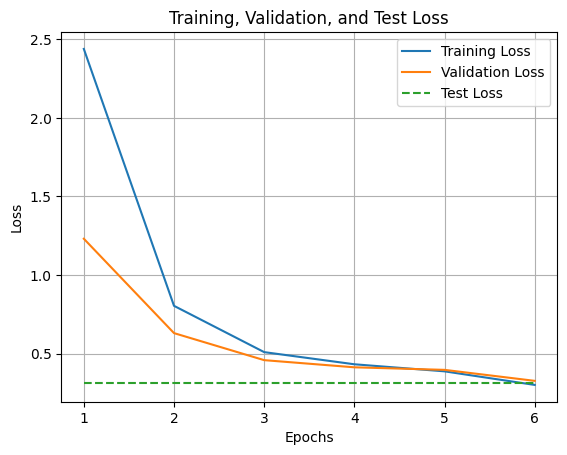

In [14]:
plot_loss(train_losses, val_losses, test_loss, num_epochs=6)


In [15]:
def plot_confusion_matrix(model, test_loader, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()


In [16]:
def plot_roc_curve(model, test_loader, num_classes):
    model.eval()
    all_labels = []
    all_outputs = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            all_outputs.append(outputs.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    all_outputs = np.vstack(all_outputs)
    all_labels = np.hstack(all_labels)
    all_labels_binarized = label_binarize(all_labels, classes=range(num_classes))
    
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(all_labels_binarized[:, i], all_outputs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.2f})")

    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve for Each Class")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()



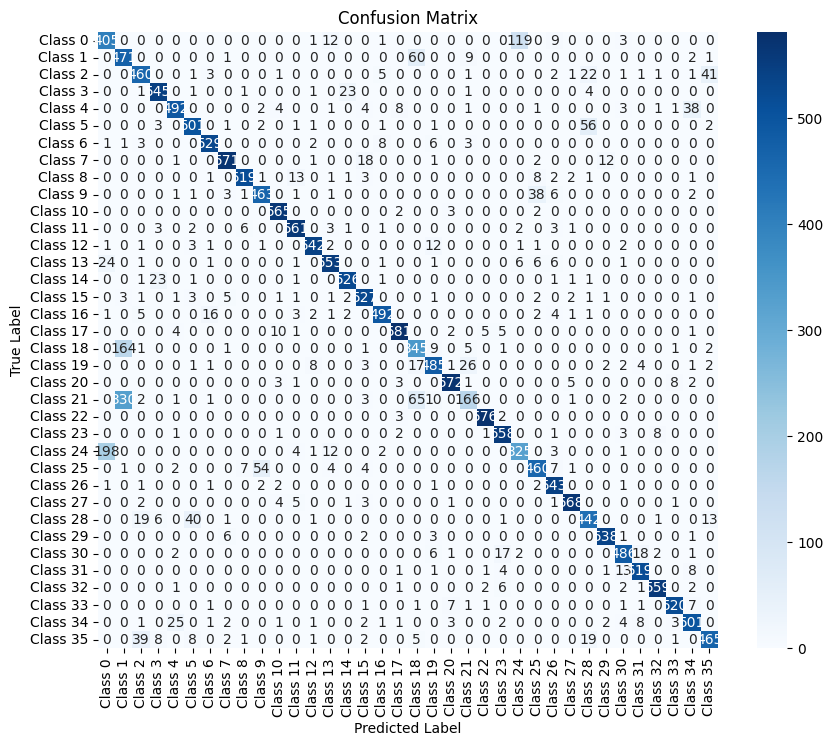

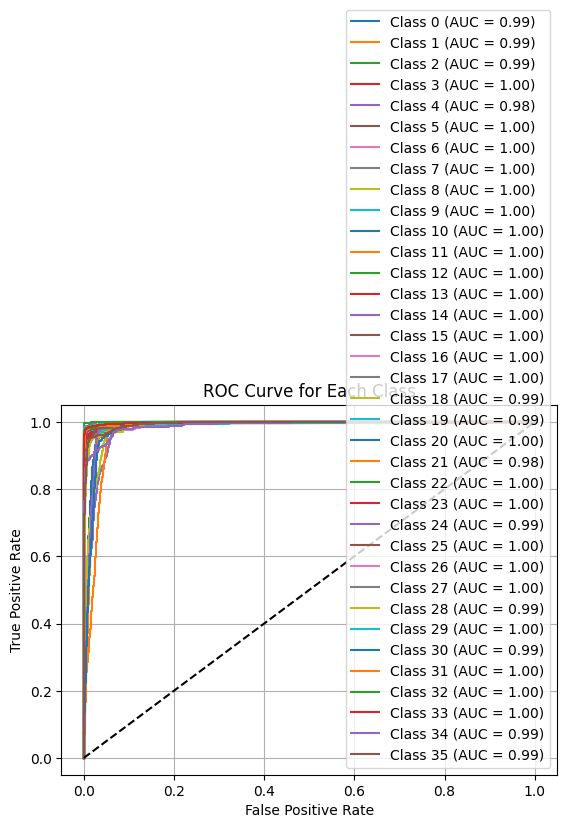

In [17]:
class_names = [f"Class {i}" for i in range(36)]
plot_confusion_matrix(model, test_loader, class_names)
plot_roc_curve(model, test_loader, num_classes=36)